In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Memoria GPU configurada correctamente


In [2]:
#1. Imports

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [3]:
#2. Paths y parámetros globales

# Modelo entrenado
MODEL_PATH = "att_unet_final.h5"

# Dataset de test
TEST_CSV = "test_split.csv"

# Rutas de imágenes y máscaras
BASE_IMG  = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"

IMG_SIZE = (384,384)

In [4]:
#3. Métricas para evaluación

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    return (2 * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def sensitivity(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-6)

def specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp + 1e-6)

In [5]:
#4. Funciones de carga del dataset
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, -1)
    return img

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, -1)
    return mask

In [6]:
#5. Cargar test_split.csv

test_df = pd.read_csv(TEST_CSV)
print(test_df.head())

                                                 img  \
0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   

                                                mask       center  
0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Goya_Madrid  
1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...    Barcelona  
2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Goya_Madrid  
3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Guadalajara  
4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...       Getafe  


In [7]:
#6. Cargar modelo Attention U-Net

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))


model = load_model(
    MODEL_PATH,
    custom_objects={
        "dice_coef": dice_coef,
        "bce_dice_loss": bce_dice_loss
    }
)

print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [8]:
#7. Evaluación imagen por imagen

results = []

for idx, row in test_df.iterrows():
    img_path  = row["img"]
    mask_path = row["mask"]
    center = row["center"]

    img = load_image(img_path)
    mask = load_mask(mask_path)

    pred = model.predict(img[None,...])[0,...,0]
    pred_bin = (pred > 0.5).astype(np.float32)

    d = dice_coef(mask[...,0], pred_bin)
    j = iou_coef(mask[...,0], pred_bin)
    sen = sensitivity(mask[...,0], pred_bin)
    spe = specificity(mask[...,0], pred_bin)

    results.append({
        "center": center,
        "img": img_path,
        "dice": d,
        "iou": j,
        "sensitivity": sen,
        "specificity": spe
    })

1/1 [==============================] - 0s 23ms/step


In [9]:
#8. Convertir resultados a DataFrame

res_df = pd.DataFrame(results)
res_df.to_csv("Resultados Modelos/att_unet_results.csv", index=False)

res_df.head()

,center,img,dice,iou,sensitivity,specificity
0,Goya_Madrid,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,"tf.Tensor(0.9273543, shape=(), dtype=float32)",0.864549,0.932884,0.986595
1,Barcelona,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,"tf.Tensor(0.94308263, shape=(), dtype=float32)",0.892296,0.930178,0.995342
2,Goya_Madrid,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,"tf.Tensor(0.93574923, shape=(), dtype=float32)",0.879256,0.896776,0.996923
3,Guadalajara,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,"tf.Tensor(0.93782, shape=(), dtype=float32)",0.882920,0.930486,0.993917
4,Getafe,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,"tf.Tensor(0.9800363, shape=(), dtype=float32)",0.960854,0.968728,0.998365


In [10]:
#9. Métricas globales

print("Dice medio:", res_df["dice"].mean())
print("IoU medio:", res_df["iou"].mean())
print("Sensibilidad media:", res_df["sensitivity"].mean())
print("Especificidad media:", res_df["specificity"].mean())

Dice medio: 0.9005700296430446
IoU medio: 0.8326323413813904
Sensibilidad media: 0.889105356232633
Especificidad media: 0.9905938709630991


In [11]:
#10. Métricas por centro

center_stats = res_df.groupby("center")[["dice","iou","sensitivity","specificity"]].mean()
print(center_stats)

center_stats.to_csv("Resultados Modelos/att_unet_results_by_center.csv")

                 dice       iou  sensitivity  specificity
center                                                   
Albacete     0.910774  0.839780     0.899952     0.989802
Barcelona    0.939823  0.887199     0.913592     0.995485
Caceres      0.820723  0.742723     0.790560     0.990486
Getafe       0.924224  0.862715     0.919047     0.991265
Goya_Madrid  0.922287  0.860340     0.918613     0.988942
Guadalajara  0.908329  0.837551     0.941450     0.988172
La_Paz       0.861563  0.782904     0.805654     0.994819
Navarra       0.86806  0.784888     0.878182     0.983028
Salamanca    0.935964  0.880971     0.929478     0.992980


1/1 [==============================] - 0s 321ms/step


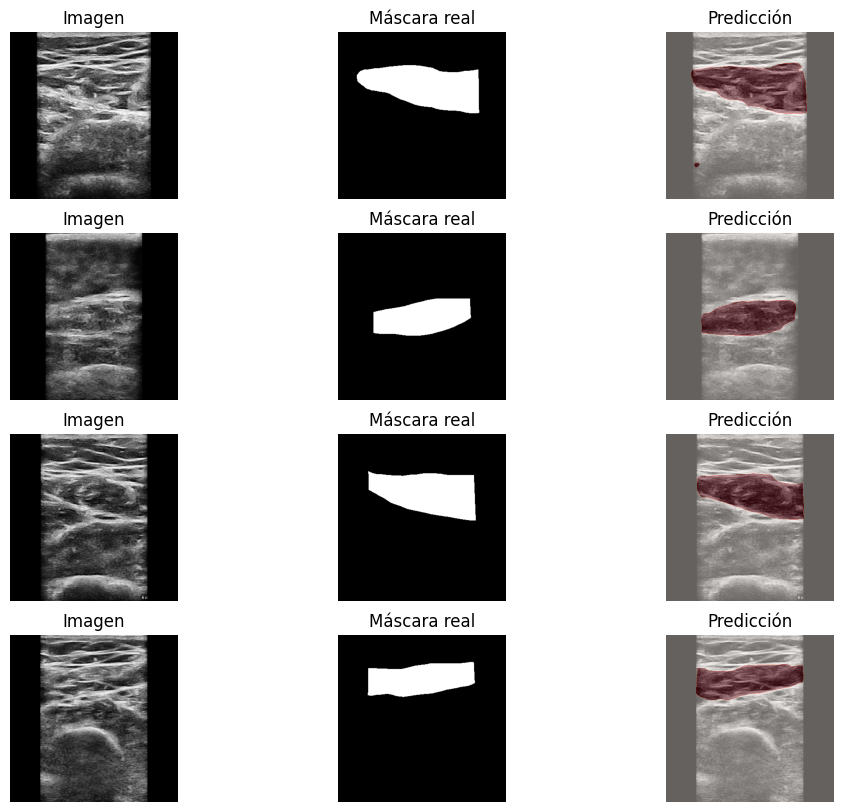

In [14]:
#11. Visualización de resultados
def show_prediction(model, dataset, n=4):
    batch = next(iter(dataset))
    imgs, masks = batch

    preds = model.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.float32)

    plt.figure(figsize=(12, 10))

    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(imgs[i,...,0], cmap='gray')
        plt.title("Imagen")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+2)
        plt.imshow(masks[i,...,0], cmap='gray')
        plt.title("Máscara real")
        plt.axis("off")

        plt.subplot(n, 3, 3*i+3)
        plt.imshow(imgs[i,...,0], cmap='gray')
        plt.imshow(preds_bin[i,...,0], cmap='Reds', alpha=0.4)
        plt.title("Predicción")
        plt.axis("off")

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def load_pair(img_path, mask_path):
    img = load_image(img_path.numpy().decode())
    mask = load_mask(mask_path.numpy().decode())
    return img, mask

def tf_wrapper(img_path, mask_path):
    img, mask = tf.py_function(
        load_pair,
        [img_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([384, 384, 1])
    mask.set_shape([384, 384, 1])
    return img, mask

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["img"].values, test_df["mask"].values)
)

test_ds = test_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(4).prefetch(tf.data.AUTOTUNE)

show_prediction(model, test_ds, n=4)